# PyTorch: IBA (Per-Sample Bottleneck)

This notebook shows how to apply the Per-Sample Bottleneck to pretrained ImageNet models. 

Ensure that `./imagenet` points to your copy of the ImageNet dataset. 

You might want to create a symlink:

In [ ]:
from google.colab import drive
import sys
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
sys.path.append('/content/drive/MyDrive/Prak_MLMI')
sys.path.append('/content/drive/MyDrive')
sys.path.append('/content/drive/MyDrive/Prak_MLMI/model')

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import matplotlib.patches as patches

In [ ]:
# to set you cuda device
%env CUDA_VISIBLE_DEVICES=0

%load_ext autoreload
%autoreload 2

import torch
import torchvision.models 
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize, Normalize, Grayscale
import matplotlib.pyplot as plt 
import os
from tqdm import tqdm_notebook
import json
from PIL import Image
import numpy as np
import sys

try:
    import IBA
except ModuleNotFoundError:
    sys.path.insert(0, '..')
    import IBA
  
from IBA.pytorch import IBA, tensor_to_np_img
from IBA.utils import plot_saliency_map

import cxr_dataset as CXR
import visualize_prediction as V

env: CUDA_VISIBLE_DEVICES=0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#!unzip "/content/drive/MyDrive/NIH_CXR14_Resized.zip" -d "/content/drive/MyDrive/NIH_CXR14_Resized"
!unzip "/content/drive/MyDrive/NIH_CXR14_Resized.zip" -d /content/

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/NIH small/00028897_014.png  
  inflating: /content/NIH small/00028897_015.png  
  inflating: /content/NIH small/00028897_016.png  
  inflating: /content/NIH small/00028897_017.png  
  inflating: /content/NIH small/00028897_018.png  
  inflating: /content/NIH small/00028897_019.png  
  inflating: /content/NIH small/00028897_020.png  
  inflating: /content/NIH small/00028898_000.png  
  inflating: /content/NIH small/00028899_000.png  
  inflating: /content/NIH small/00028899_001.png  
  inflating: /content/NIH small/00028899_002.png  
  inflating: /content/NIH small/00028900_000.png  
  inflating: /content/NIH small/00028901_000.png  
  inflating: /content/NIH small/00028901_001.png  
  inflating: /content/NIH small/00028902_000.png  
  inflating: /content/NIH small/00028902_001.png  
  inflating: /content/NIH small/00028902_002.png  
  inflating: /content/NIH small/00028902_003.png  
  inflating: /content/NIH small/00028902_004.png  
  in

## Loading Data and Model

In [ ]:
prak_dir = '/content/drive/MyDrive/Prak_MLMI'
imagenet_dir = '/content/drive/MyDrive/Prak_MLMI/imagenet'
PATH_TO_IMAGES = "/content/NIH small"
#PATH_TO_IMAGES = "/content/drive/MyDrive/NIH_CXR14_Resized/NIH small"
#PATH_TO_IMAGES = prak_dir + "/NIH small"   
#PATH_TO_IMAGES = "/content/drive/MyDrive/NIH small"  
MODEL_PATH = prak_dir + '/model/results/checkpoint_best'
label_path = '/content/drive/MyDrive/Prak_MLMI/model/labels'

dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

checkpoint = torch.load(MODEL_PATH, map_location=dev)
model = checkpoint['model'].module
model.to(dev).eval()
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
# load the data

# use imagenet mean,std for normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

data_transforms = {
    'train': Compose([
        Resize(224),
        CenterCrop(224),
        ToTensor(),
        Normalize(mean, std)
    ]),
    'val': Compose([
        Resize(224),
        CenterCrop(224),
        ToTensor(),
        Normalize(mean, std)
    ]),
}

# create dataloader
# use fine_tune = False to load NIH dataset
# dataset = CXR.CXRDataset(
#     path_to_images=PATH_TO_IMAGES,
#     fold='train',
#     transform=data_transforms['train'],
#     fine_tune=False,
#     label_path=label_path)
# dataloader = DataLoader(dataset, 64, shuffle=True, num_workers=8)

bounding_box_transform = CXR.RescaleBB(224, 1024)

LABEL='Pneumonia'

dataset = CXR.CXRDataset(
    path_to_images=PATH_TO_IMAGES,
    fold='BBox',#fold='train'
    transform=data_transforms['train'],
    transform_bb=bounding_box_transform,
    fine_tune=False,
    label_path=label_path)  #finding=LABEL
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=1)
 

In [ ]:
len(iter(dataloader))

984

In [ ]:
len(dataloader)

984

In [ ]:


# preds=V.show_next(iter(dataloader),model, LABEL)
# preds

In [ ]:
PATH_TO_IMAGES

'/content/NIH small'

In [ ]:
cd /content/drive/MyDrive/Prak_MLMI/NIH small

/content/drive/.shortcut-targets-by-id/1enx5icY_xs_zL8wzRs-4M4FXkI3AvIfQ/Prak_MLMI/NIH small


In [ ]:
# print example label and index
img, label, idx, bb = dataset[0]
print(label)
print(idx)
print(bb)

len(dataset)

[0 1 0 1 0 0 0 0 0 1 0 0 0 0]
00000032_037.png
[74.19259259 26.07407407 37.68888889 76.8       ]


984

### Insert the bottleneck into the model for NIH

You can experiment with the location of the bottleneck.

In [ ]:
iba = IBA(model.features.denseblock2.denselayer6)

In [ ]:
iba.reset_estimate()

## Estimate Mean and Variance

Here, we estimate the mean and variances of the feature map. It is important for measuring the amount of information transmitted.

In [ ]:
iba.estimate(model, dataloader, device=dev, n_samples=10, progbar=True)

In [ ]:
neuron = (12, 3, 4)
print("Neuron at position {:} has mean {:.2f} and std {:.2f}".format(
    neuron, iba.estimator.mean()[neuron],  iba.estimator.std()[neuron]))

#(12, 3, 4) has mean -0.03 and std 0.17


Neuron at position (12, 3, 4) has mean -0.04 and std 0.09


In [ ]:
iba.estimator.n_samples()

64

## Random images from the training set  (Question: normalize with imagenet mean and std, should calculate our own?)  inserted in denseblock2.denselayer6

In [ ]:
%matplotlib inline

In [ ]:
# def model_loss_closure(input):
#   loss = torch.nn.BCEWithLogitsLoss()
#   mse_loss = loss(model(input), torch.unsqueeze((torch.tensor(target).to(dev)).float(), 0).expand(10, -1))
#   return mse_loss
def model_loss_closure(input):
  loss = nn.BCEWithLogitsLoss()
  mse_loss = loss(model(input), torch.tensor(target).view(1,-1).expand(10, -1).to(dev).float())
  return mse_loss


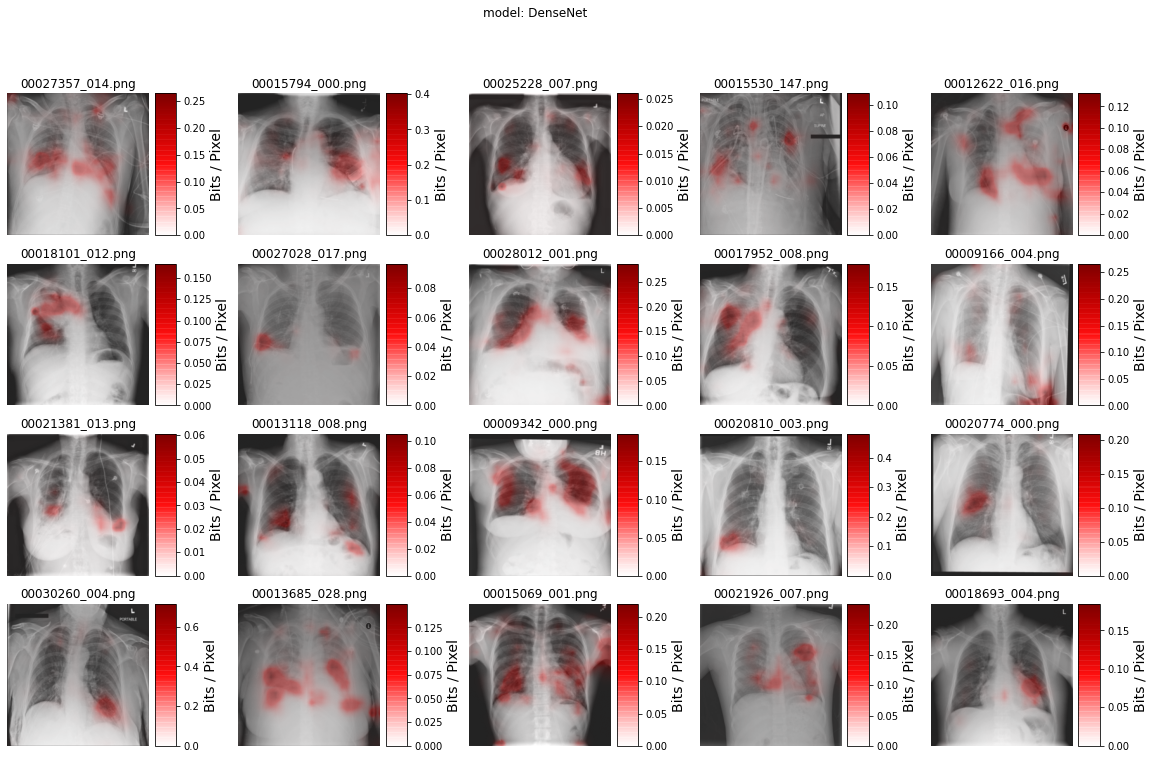

In [ ]:
 
fig, axes = plt.subplots(4, 5, figsize=(20, 12))
seed = np.random.randint(0, 1000000000)
np.random.seed(seed)
iba.reverse_lambda = False
iba.beta = 0.5


for ax, sample_idx in zip(axes.flatten(), np.random.choice(980, 20)):
    img, target, idx, bb = dataset[sample_idx]

    img = img[None].to(dev)
    
    # execute the model on a given sample and return the target NLL
    # model_loss_closure = lambda x: torch.nn.BCEWithLogitsLoss(model(x), torch.tensor(target).to(dev))

    
    # generate the heatmap
    heatmap = iba.analyze(img, model_loss_closure)
    
    # reverse the data pre-processing for plotting the original image
    np_img = tensor_to_np_img(img[0])
    
    # show the heatmap
    plot_saliency_map(heatmap, np_img,  ax=ax)
    ax.set_title(idx)
    
fig.suptitle("model: {}".format(type(model).__name__))
plt.show()


with bounding box

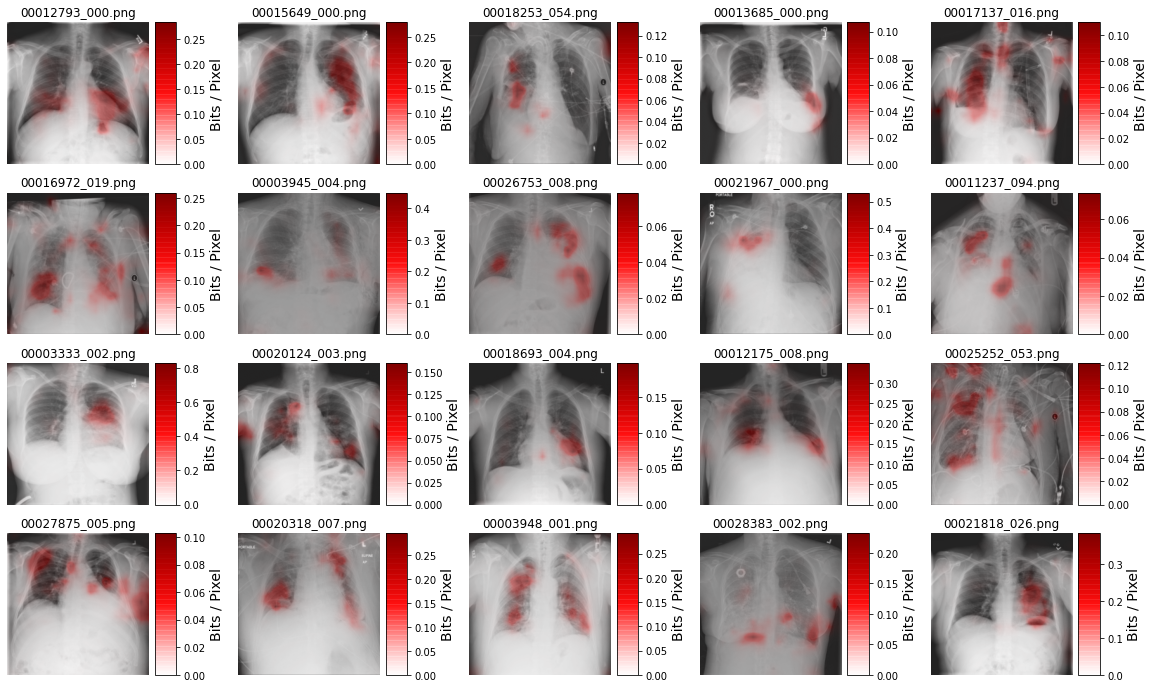

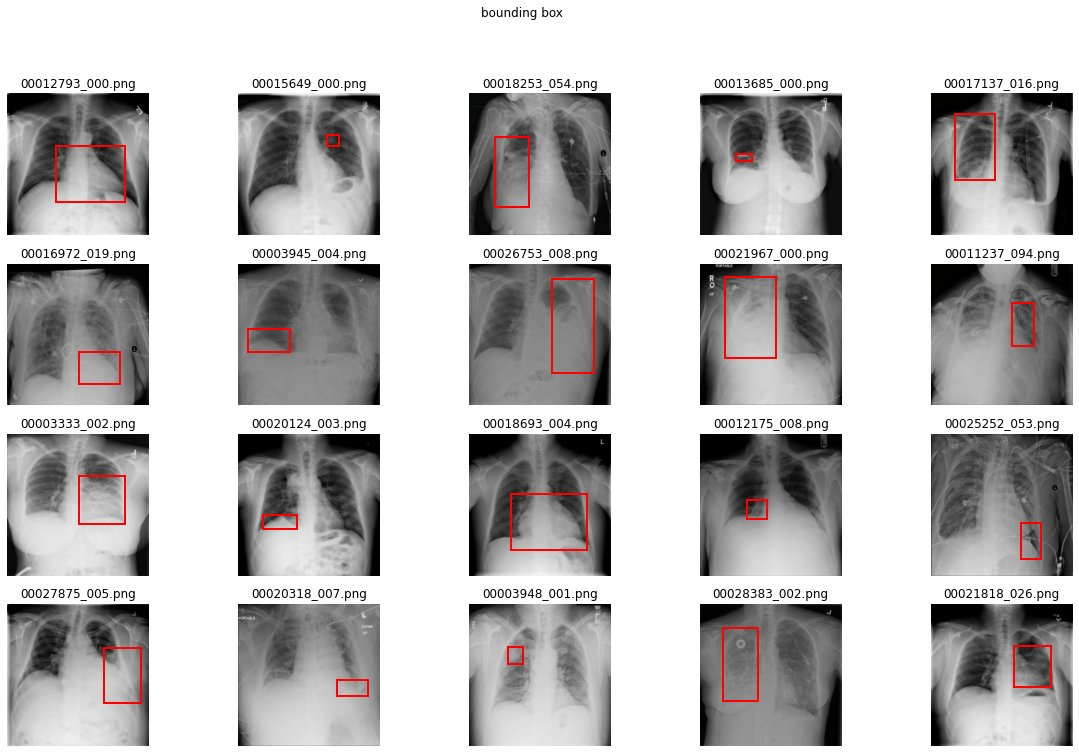

In [ ]:
seed = np.random.randint(0, 1000000000)
fig, axes = plt.subplots(4, 5, figsize=(20, 12))

fig2, axes2 = plt.subplots(4, 5, figsize=(20, 12))
np.random.seed(seed)
iba.reverse_lambda = False
iba.beta = 0.5
for ax, sample_idx, ax2 in zip(axes.flatten(), np.random.choice(900, 20), axes2.flatten()):
    img, target, idx, bbox = dataset[sample_idx]
    img = img[None].to(dev)
    
    # execute the model on a given sample and return the target NLL
    # model_loss_closure = lambda x: -torch.log_softmax(model(x), 1)[:, target].mean()
    
    # generate the heatmap
    heatmap = iba.analyze(img, model_loss_closure)
    
    # reverse the data pre-processing for plotting the original image
    np_img = tensor_to_np_img(img[0])
    
    # show the heatmap
    plot_saliency_map(heatmap, np_img,  ax=ax)
    ax.set_title(idx)


    cxr = img.data.cpu().numpy().squeeze().transpose(1, 2, 0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    cxr = std * cxr + mean
    cxr = np.clip(cxr, 0, 1)

#    rect_original = patches.Rectangle((bbox[0, 0], bbox[0, 1]), bbox[0, 2], bbox[0, 3], linewidth=2, edgecolor='r', facecolor='none', zorder=2)
    rect_original = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none', zorder=2)

    ax2.imshow(cxr)
    ax2.axis('off')
    ax2.set_title(idx)
    ax2.add_patch(rect_original) 
 




  
fig2.suptitle("bounding box")
plt.show()

## Choose some specific image

Old method


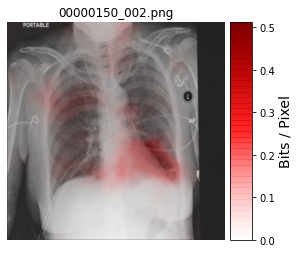

Ground truth with bounding box


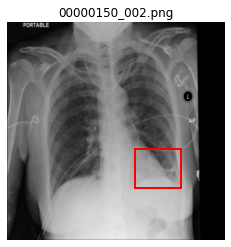

New method


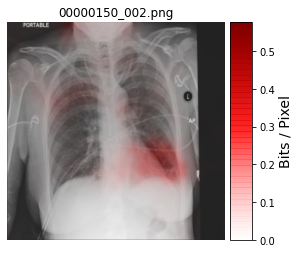

In [ ]:


for sample_idx in range(len(dataset)):
    img, target, idx, bbox = dataset[sample_idx]
    if idx == "00000150_002.png":

      img = img[None].to(dev)
      np_img = tensor_to_np_img(img[0])

      print("Old method")
      iba.reverse_lambda = False
      iba.beta = 0.5
      #model_loss_closure = lambda x: -torch.log_softmax(model(x), 1)[:, target].mean()
      heatmap = iba.analyze(img, model_loss_closure)  
      # show the heatmap
      ax = plot_saliency_map(heatmap, np_img)
      _ = ax.set_title(idx)
      plt.show()

      print("Ground truth with bounding box")
      cxr = img.data.cpu().numpy().squeeze().transpose(1, 2, 0)
      mean = np.array([0.485, 0.456, 0.406])
      std = np.array([0.229, 0.224, 0.225])
      cxr = std * cxr + mean
      cxr = np.clip(cxr, 0, 1)

    # rect_original = patches.Rectangle((bbox[0, 0], bbox[0, 1]), bbox[0, 2], bbox[0, 3], linewidth=2, edgecolor='r', facecolor='none', zorder=2)
      rect_original = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none', zorder=2)
      
      fig, ax2 = plt.subplots(1, 1, figsize=(5.5, 4.0))

      ax2.imshow(cxr)
      ax2.axis('off')
      ax2.set_title(idx)
      ax2.add_patch(rect_original) 
      plt.show()

      print("New method")
      iba.reverse_lambda = True
      iba.beta = 0.5
      #model_loss_closure = lambda x: -torch.log_softmax(model(x), 1)[:, target].mean()
      heatmap = iba.analyze(img, model_loss_closure) 
      # show the heatmap
      ax3 = plot_saliency_map(heatmap, np_img)
      _ = ax3.set_title(idx)
      plt.show()
 

 
    
 
 



 



 

## Try with different layers (old method)

In [ ]:
# load image
fig, axes = plt.subplots(2, 4, figsize=(20,15))

positions = [["1","1"], ["1","6"], ["2","6"],["2","12"],["3","12"],["3","24"],["4","8"],["4","16"]]

for position, ax in zip(positions, axes.flatten()):
    current_pos = "model.features.denseblock{0}.denselayer{1}".format(*position)
    iba = IBA(eval(current_pos))
    iba.reset_estimate()
    iba.estimate(model, trainloader, device=dev, n_samples=10, progbar=False)

    model_loss_closure = lambda x: -torch.log_softmax(model(x), 1)[:, target].mean()
    heatmap = iba.analyze(img[None].to(dev), model_loss_closure) 
    ax = plot_saliency_map(heatmap, tensor_to_np_img(img), ax=ax)
    ax.set_title(current_pos)

plt.show()

In [ ]:
iba.reverse_lambda

# Try with different layers (new method)

In [ ]:
print("New method")

# load image
fig, axes = plt.subplots(2, 4, figsize=(20,15))

positions = [["1","1"], ["1","6"], ["2","6"],["2","12"],["3","12"],["3","24"],["4","8"],["4","16"]]

for position, ax in zip(positions, axes.flatten()):
    current_pos = "model.features.denseblock{0}.denselayer{1}".format(*position)
    iba = IBA(eval(current_pos))
    iba.reset_estimate()
    iba.estimate(model, trainloader, device=dev, n_samples=10, progbar=False)
    iba.reverse_lambda = True
    iba.beta = 30

    model_loss_closure = lambda x: -torch.log_softmax(model(x), 1)[:, target].mean()
    heatmap = iba.analyze(img[None].to(dev), model_loss_closure) 
    ax = plot_saliency_map(heatmap, tensor_to_np_img(img), ax=ax)
    ax.set_title(current_pos)

plt.show()